## 第一題 [分類器、特徵建構、與Stacking]

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import numpy as np

f = open('ds/namesex_data_v2.csv', 'r', encoding='utf8')
mydata = csv.DictReader(f)
sexlist = []
namelist = []
foldlist = []
for i, arow in enumerate(mydata):
    if i < 10:
        print(arow)
    sexlist.append(int(arow['sex'].strip()))
    gname = arow['gname'].strip()
    namelist.append(gname)
    foldlist.append(int(arow['fold'].strip()))

sexlist = np.asarray(sexlist)
namelist = np.asarray(namelist)
foldlist = np.asarray(foldlist)
f.close()

OrderedDict([('gname', '承憲'), ('sex', '1'), ('fold', '9')])
OrderedDict([('gname', '均平'), ('sex', '1'), ('fold', '7')])
OrderedDict([('gname', '思安'), ('sex', '0'), ('fold', '6')])
OrderedDict([('gname', '佑誠'), ('sex', '1'), ('fold', '3')])
OrderedDict([('gname', '乃馨'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '婕'), ('sex', '0'), ('fold', '0')])
OrderedDict([('gname', '冠瑜'), ('sex', '0'), ('fold', '1')])
OrderedDict([('gname', '冠學'), ('sex', '1'), ('fold', '0')])
OrderedDict([('gname', '立翰'), ('sex', '1'), ('fold', '2')])
OrderedDict([('gname', '以柔'), ('sex', '0'), ('fold', '6')])


In [3]:
nobs = namelist.shape[0]
print("資料筆數 = ", nobs)

avg_sex = np.mean(sexlist)
print("男性比率", avg_sex)

import pandas as pd
name_df = pd.DataFrame({'sex': sexlist, 'name': namelist, 'fold': foldlist})
sex_tend = name_df[['name', 'sex']].groupby(["name"]).agg(['mean', 'count']).reset_index()
sex_tend.columns = ['-'.join(col).strip() for col in sex_tend.columns.values]
sex_tend = sex_tend.sort_values(['sex-count'], ascending=False)

print("最常見的20個名子:")
sex_tend.head(20)

single_name = np.sum(sex_tend['sex-count'] <= 1)
print("出現一次名子個數: ", single_name, "比率:", single_name / nobs)

ind1 = (sex_tend['sex-mean'] > 0.4) & (sex_tend['sex-mean'] < 0.6)
sex_amb = sex_tend[ind1]
amb_count = sex_amb['sex-count'].sum()
print("難區分性別姓名數量: ", amb_count, "比率:", amb_count/ nobs)

資料筆數 =  10730
男性比率 0.47940354147250697
最常見的20個名子:
出現一次名子個數:  7067 比率: 0.6586206896551724
難區分性別姓名數量:  136 比率: 0.012674743709226468


In [4]:
name_df['1'] = list(x[0] for x in list(name_df['name']))
name_df['2'] = list(x[1] if len(x) > 1 else x[0] for x in list(name_df['name']))
name_oh_enc = pd.get_dummies(name_df) 

name_sel = pd.DataFrame()
for i in name_oh_enc:
    if '1_' in i or '2_' in i:
        if i[2:] not in name_sel:
            name_sel[i[2:]] = name_oh_enc[i]
        else:
            name_sel[i[2:]] = name_sel[i[2:]] + name_oh_enc[i]
    elif 'name_' in i:
        if i[5:] not in name_sel:
            name_sel[i[5:]] = name_oh_enc[i]
        else:
            name_sel[i[5:]] = name_sel[i[5:]] + name_oh_enc[i]

In [5]:
name_sel['fold'] = name_oh_enc['fold']

temp = []
for i in name_sel:
    if (list(name_sel[i][name_sel['fold'] <= 6] != 0).count(True)) >= 2:
        temp.append(i)
name_sel = name_sel[temp]

temp = [i for i in name_df['name']]
OtherFeature = [ i in name_sel.columns for i in temp]
OtherFeature = [ 1 if i is True else 0 for i in OtherFeature]
name_sel['_OtherFeature'] = OtherFeature
name_sel['sex'] = name_oh_enc['sex']

filter = name_sel['fold'] <= 6 
trainingset = name_sel[filter]
y_train = np.array(trainingset['sex'])
x_train = np.array(trainingset.drop(columns=['sex']))

valset = name_sel[name_sel['fold'] == 7] 
y_valid = np.array(valset['sex'])
x_valid = np.array(valset.drop(columns=['sex']))

stackset = name_sel[name_sel['fold'] == 8] 
y_stack = np.array(stackset['sex'])
x_stack = np.array(stackset.drop(columns=['sex']))

testset = name_sel[name_sel['fold'] == 9] 
y_test = np.array(testset['sex'])
x_test = np.array(testset.drop(columns=['sex']))

### Q1.1

In [6]:
#print all shape

print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_stack.shape)
print(y_stack.shape)
print(x_test.shape)
print(y_test.shape)

(7483, 1630)
(7483,)
(1110, 1630)
(1110,)
(1073, 1630)
(1073,)
(1064, 1630)
(1064,)


### Q1.2

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import linear_model
cmin = 1e-4
cmax = 1000
ngrid = 20
cgrids = np.geomspace(cmin, cmax, ngrid)
a = np.zeros(ngrid)
for i, c in enumerate(cgrids):    
    model = linear_model.LogisticRegression(C=c)
    model.fit(x_train, y_train)
    ypred = model.predict(x_valid)
    a[i] = f1_score(y_valid, ypred, average='binary')
    
maxind = np.argmax(a)
bestc = cgrids[maxind]
print("Best c = %f" % bestc)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbf

Best c = 78.475997


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [8]:
x_train2 = np.concatenate((x_train, x_valid), axis = 0)
y_train2 = np.concatenate((y_train, y_valid))

model2 = linear_model.LogisticRegression(C=bestc, solver='lbfgs', max_iter=1000)
model2.fit(x_train2, y_train2)
ypred = model2.predict(x_test)

print("Accuracy = ", accuracy_score(y_test, ypred))
print("Precision = ", precision_score(y_test, ypred, average='binary'))
print("Recall = ", recall_score(y_test, ypred, average='binary'))
print("F-1 = ", f1_score(y_test, ypred, average='binary'))
print("係數絕對值最大的20個特徵:\n", list(name_sel.columns[[abs(model2.coef_[0]).argsort()[-1::-1]]][0:20]))

Accuracy =  0.8778195488721805
Precision =  0.8493150684931506
Recall =  0.891170431211499
F-1 =  0.8697394789579158
係數絕對值最大的20個特徵:
 ['傑', '森', '玲', '妤', '婷', '雯', '凌', '萱', '美', '薇', '綾', '鋒', '婕', '潔', '嵐', '絃', '卉', '蓉', '靜', '松']


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/base.py:4291: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


#### Performance看起來不錯，Accuarcy接近88%，且以絕對值最大20特徵來看，幾乎都是一眼就能辨認性別的字，因此應該是work的

### Q1.3

In [9]:
import sklearn.ensemble as ensemble

ngrids = np.geomspace(5, 1000, 10).astype(int)
score = np.zeros(10)
for i, n in enumerate(ngrids):    
    model3 = ensemble.RandomForestClassifier(n_estimators = n, n_jobs = -1)
    model3.fit(x_train, y_train)
    ypred = model3.predict(x_valid)     
    score[i] = f1_score(y_valid, ypred, average='binary')
    
print("Best n = ", ngrids[np.argmax(score)])

Best n =  94


In [14]:
model4 = ensemble.RandomForestClassifier(n_estimators = 94, n_jobs = -1)
model4.fit(x_train2, y_train2)
ypred = model4.predict(x_test)    

print("Accuracy = ", accuracy_score(y_test, ypred))
print("Precision = ", precision_score(y_test, ypred, average='binary'))
print("Recall = ", recall_score(y_test, ypred, average='binary'))
print("F-1 = ", f1_score(y_test, ypred, average='binary'))
print("係數絕對值最大的20個特徵:\n", list(name_sel.columns[abs(model4.feature_importances_).argsort()[-2::-1]][0:20]))

Accuracy =  0.8439849624060151
Precision =  0.8045540796963947
Recall =  0.8706365503080082
F-1 =  0.8362919132149901
係數絕對值最大的20個特徵:
 ['妤', '翔', '萱', '柏', '婷', '怡', '哲', '蓁', '承', '雅', '佳', '晴', '芸', '芷', '柔', '庭', '宜', '瑄', '涵', '婕']


#### 這次的performance沒有上題好，但仍然可以從前20個特徵辨認出性別，顯示仍然是不錯的表現。

### Q1.4

In [10]:
lr = [0.1, 0.5, 1]
gbc_list = []
for i in lr:
    gbc = ensemble.GradientBoostingClassifier(n_estimators = 1500, learning_rate = i)
    gbc.fit(x_train, y_train)
    gbc_list.append(gbc)    
    
final_lr, final_f1, final_stage = 0, 0, 0
for idx in range(0, len(lr)):
    ypred2 = gbc_list[idx].staged_predict(x_valid)
    f_gbcstage = np.zeros(1500)
    for i, ypred in enumerate(ypred2):
        f_gbcstage[i] = f1_score(y_valid, ypred, average='binary')
    best_stage = np.argmax(f_gbcstage)
    best_f1 = f_gbcstage[best_stage]
    if best_f1 > final_f1:
        final_f1 = best_f1
        final_lr = lr[idx]
        final_stage = best_stage
    
gbdt = ensemble.GradientBoostingClassifier(n_estimators = final_stage, learning_rate = final_lr)
gbdt.fit(x_train2, y_train2)
ypred = gbdt.predict(x_test)    

print("Accuracy = ", accuracy_score(y_test, ypred))
print("Precision = ", precision_score(y_test, ypred, average='binary'))
print("Recall = ", recall_score(y_test, ypred, average='binary'))
print("F-1 = ", f1_score(y_test, ypred, average='binary'))
print("係數絕對值最大的20個特徵:\n", list(name_sel.columns[abs(gbdt.feature_importances_).argsort()[-1::-1]][0:20]))

Accuracy =  0.8637218045112782
Precision =  0.8143382352941176
Recall =  0.9096509240246407
F-1 =  0.8593598448108632
係數絕對值最大的20個特徵:
 ['妤', '翔', '萱', '柏', '婷', '哲', '承', '怡', '蓁', '雅', '晴', '佳', '柔', '宜', '芸', '涵', '芷', '瑄', '庭', '慈']


#### Accuracy有比上題好，但仍沒有logistic regression的佳。 仍然可以從前20個特徵辨認出性別，且多為女性。

### Q1.5

In [22]:
x1 = model2.predict_proba(x_stack)[:,[1]]
x2 = model4.predict_proba(x_stack)[:,[1]]
x3 = gbdt.predict_proba(x_stack)[:,[1]]
x_prob = np.concatenate((x1, x2, x3), axis=1)

stack_classifier = linear_model.LogisticRegression()
stack_classifier.fit(x_probstack, y_stack)

stack_classifier.coef_

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[3.40725022, 0.44242409, 3.03595544]])

#### 由係數看得出來，random forest預測能力最差，而logistic regression預測能力最好，gbdtree的預測能力也不差。

In [23]:
x1 = model2.predict_proba(x_test)[:,[1]]
x2 = model4.predict_proba(x_test)[:,[1]]
x3 = gbdt.predict_proba(x_test)[:,[1]]
x_probtest = np.concatenate((x1, x2, x3), axis=1)

ypred = stack_classifier.predict(x_probtest)

print("Accuracy = ", accuracy_score(y_test, ypred))
print("Precision = ", precision_score(y_test, ypred, average='binary'))
print("Recall = ", recall_score(y_test, ypred, average='binary'))
print("F-1 = ", f1_score(y_test, ypred, average='binary'))

Accuracy =  0.8806390977443609
Precision =  0.8501945525291829
Recall =  0.8973305954825462
F-1 =  0.8731268731268731


#### Stacking classifier的Accuracy較其他單一模型得更好

## 第二題 [Data Visualization via Dimensionality Reduction]

### Q2.1

In [163]:
import matplotlib.patches as mpatches

color_map = {"1":"r", "2": "coral", "3": "orange", "4": "y", "5": "lime", "6":"limegreen", "7":"g", "8":"deepskyblue", "9":"cornflowerblue", "10":"b", "99":"purple"}
category_dic = uname.set_index('category_id')['category_name'].to_dict()
label_color = []
dep_id_list = new_stu.index.tolist()
for i in range(len(new_stu)):
    dep_id = dep_id_list[i]
    category_id = uname.loc[uname['department_id'] == dep_id, 'category_id']
    label_color.append(color_map[category_id.values[0]])

patchList = []
for key in category_dic:
        data_key = mpatches.Patch(color=label_color_map[key], label=category_dic[key])
        patchList.append(data_key)
        

Text(0.5, 1.0, 'PCA')

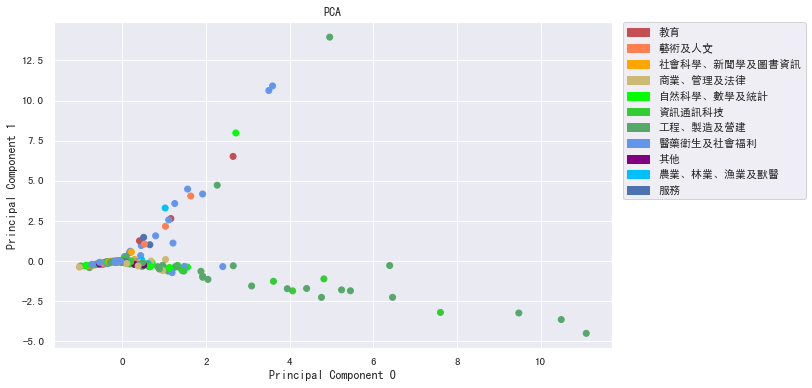

In [167]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = [10, 6]

dep_category_map = new_stu.merge(uname.loc[:,['department_id','category_name']], on='department_id').rename(columns={'category_name':'dep_category'}).reset_index().loc[:,['department_id','dep_category']]
X = new_stu.iloc[:,:-2]

pca = PCA(n_components = 8)
X_pca = pca.fit_transform(new_stu)

plt.scatter(X_pca[:,0], X_pca[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.title('PCA')

Text(0.5, 1.0, 'PCA')

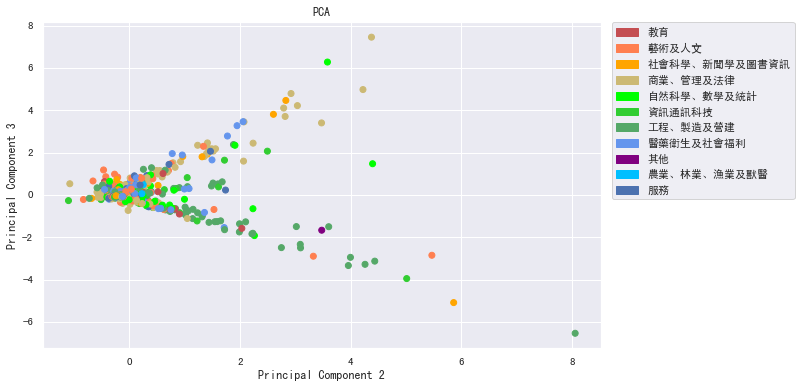

In [168]:
plt.scatter(X_pca[:,2], X_pca[:,3], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.xlabel('Principal Component 2')
plt.ylabel('Principal Component 3')
plt.title('PCA')

Text(0.5, 1.0, 'PCA')

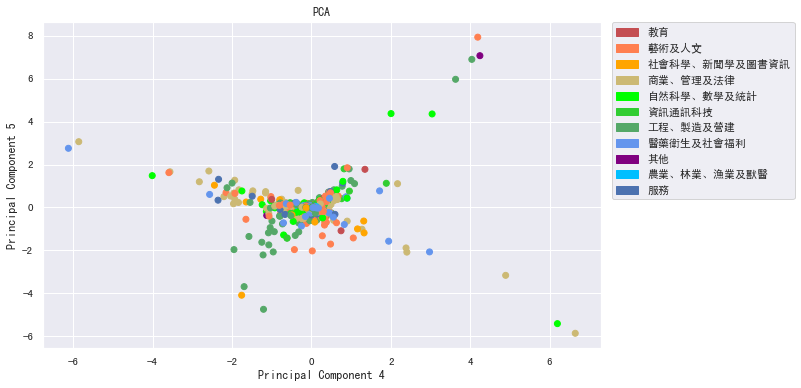

In [169]:
plt.scatter(X_pca[:,4], X_pca[:,5], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.xlabel('Principal Component 4')
plt.ylabel('Principal Component 5')
plt.title('PCA')

Text(0.5, 1.0, 'PCA')

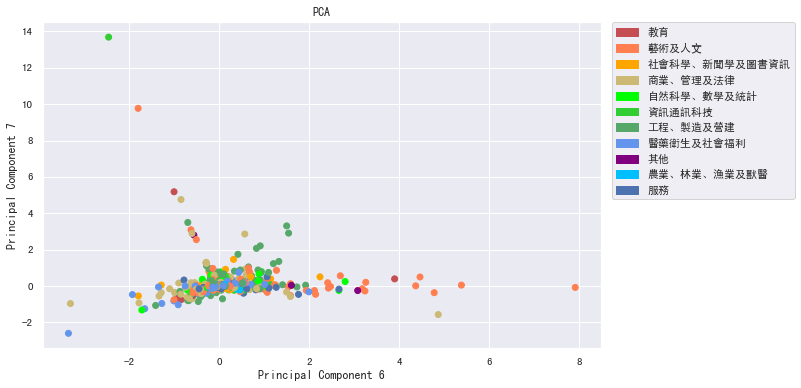

In [170]:
plt.scatter(X_pca[:,6], X_pca[:,7], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.xlabel('Principal Component 6')
plt.ylabel('Principal Component 7')
plt.title('PCA')

#### 看得出有些點可以被抓出來，但是大部分還是會聚集在一起，也許不是最好的分類器

### Q2.2

Text(0.5, 1.0, 'MDS (metric)')

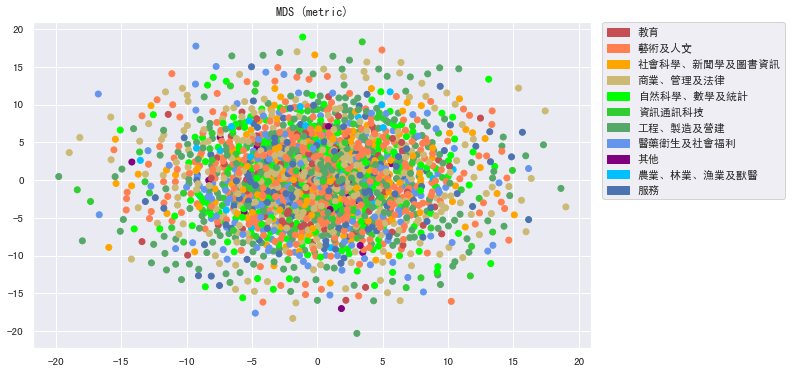

In [171]:
from sklearn.manifold import MDS

mds = MDS(metric = True, n_jobs = -1)
X_mds = mds.fit_transform(new_stu)
plt.scatter(X_mds[:,0], X_mds[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('MDS (metric)')

Text(0.5, 1.0, 'MDS (non-metric)')

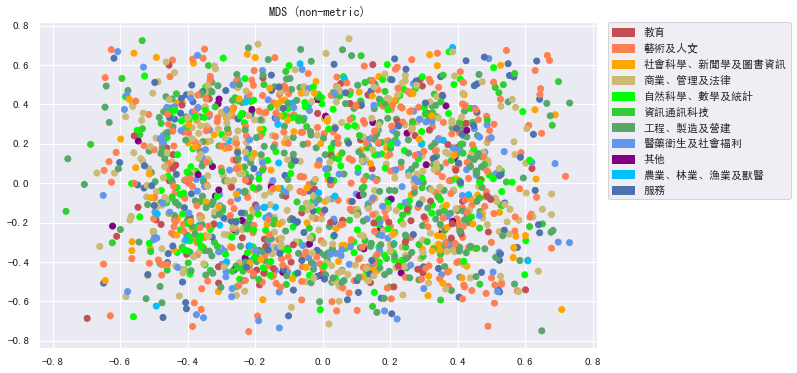

In [173]:
from sklearn.manifold import MDS

mds = MDS(metric = False, n_jobs = -1)
X_mds = mds.fit_transform(new_stu)
plt.scatter(X_mds[:,0], X_mds[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('MDS (non-metric)')

#### 從兩種case中的點分佈來看，MDS的結果非常不好，很難看出什麼insight

### Q2.3

Text(0.5, 1.0, 'Locally Linear Embedding (20 neighbors)')

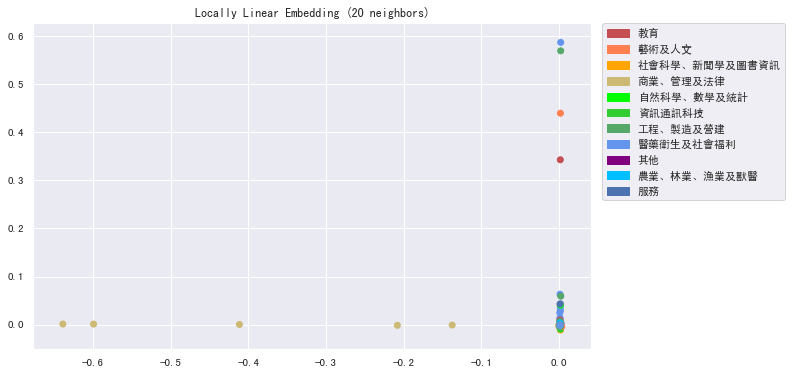

In [174]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 20, n_jobs = -1)
X_lle = lle.fit_transform(new_stu)
plt.scatter(X_lle[:,0], X_lle[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('Locally Linear Embedding (20 neighbors)')

Text(0.5, 1.0, 'Locally Linear Embedding (40 neighbors)')

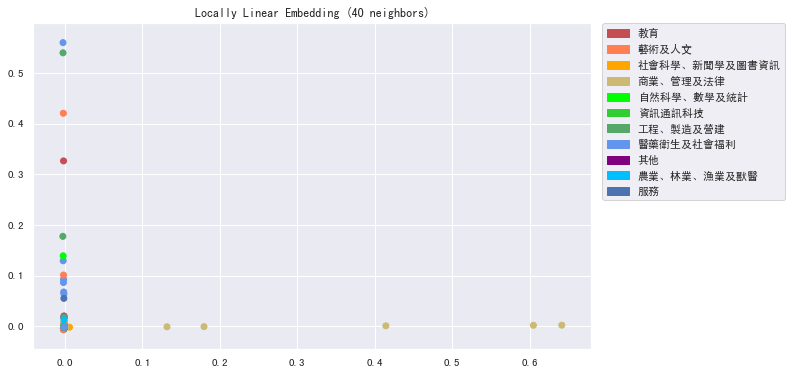

In [175]:
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 40, n_jobs = -1)
X_lle = lle.fit_transform(new_stu)
plt.scatter(X_lle[:,0], X_lle[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('Locally Linear Embedding (40 neighbors)')

Text(0.5, 1.0, 'PCA + LLE(20 neighbors)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 25945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 32946 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 34269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 34899 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 21450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.7/site-packages/matpl

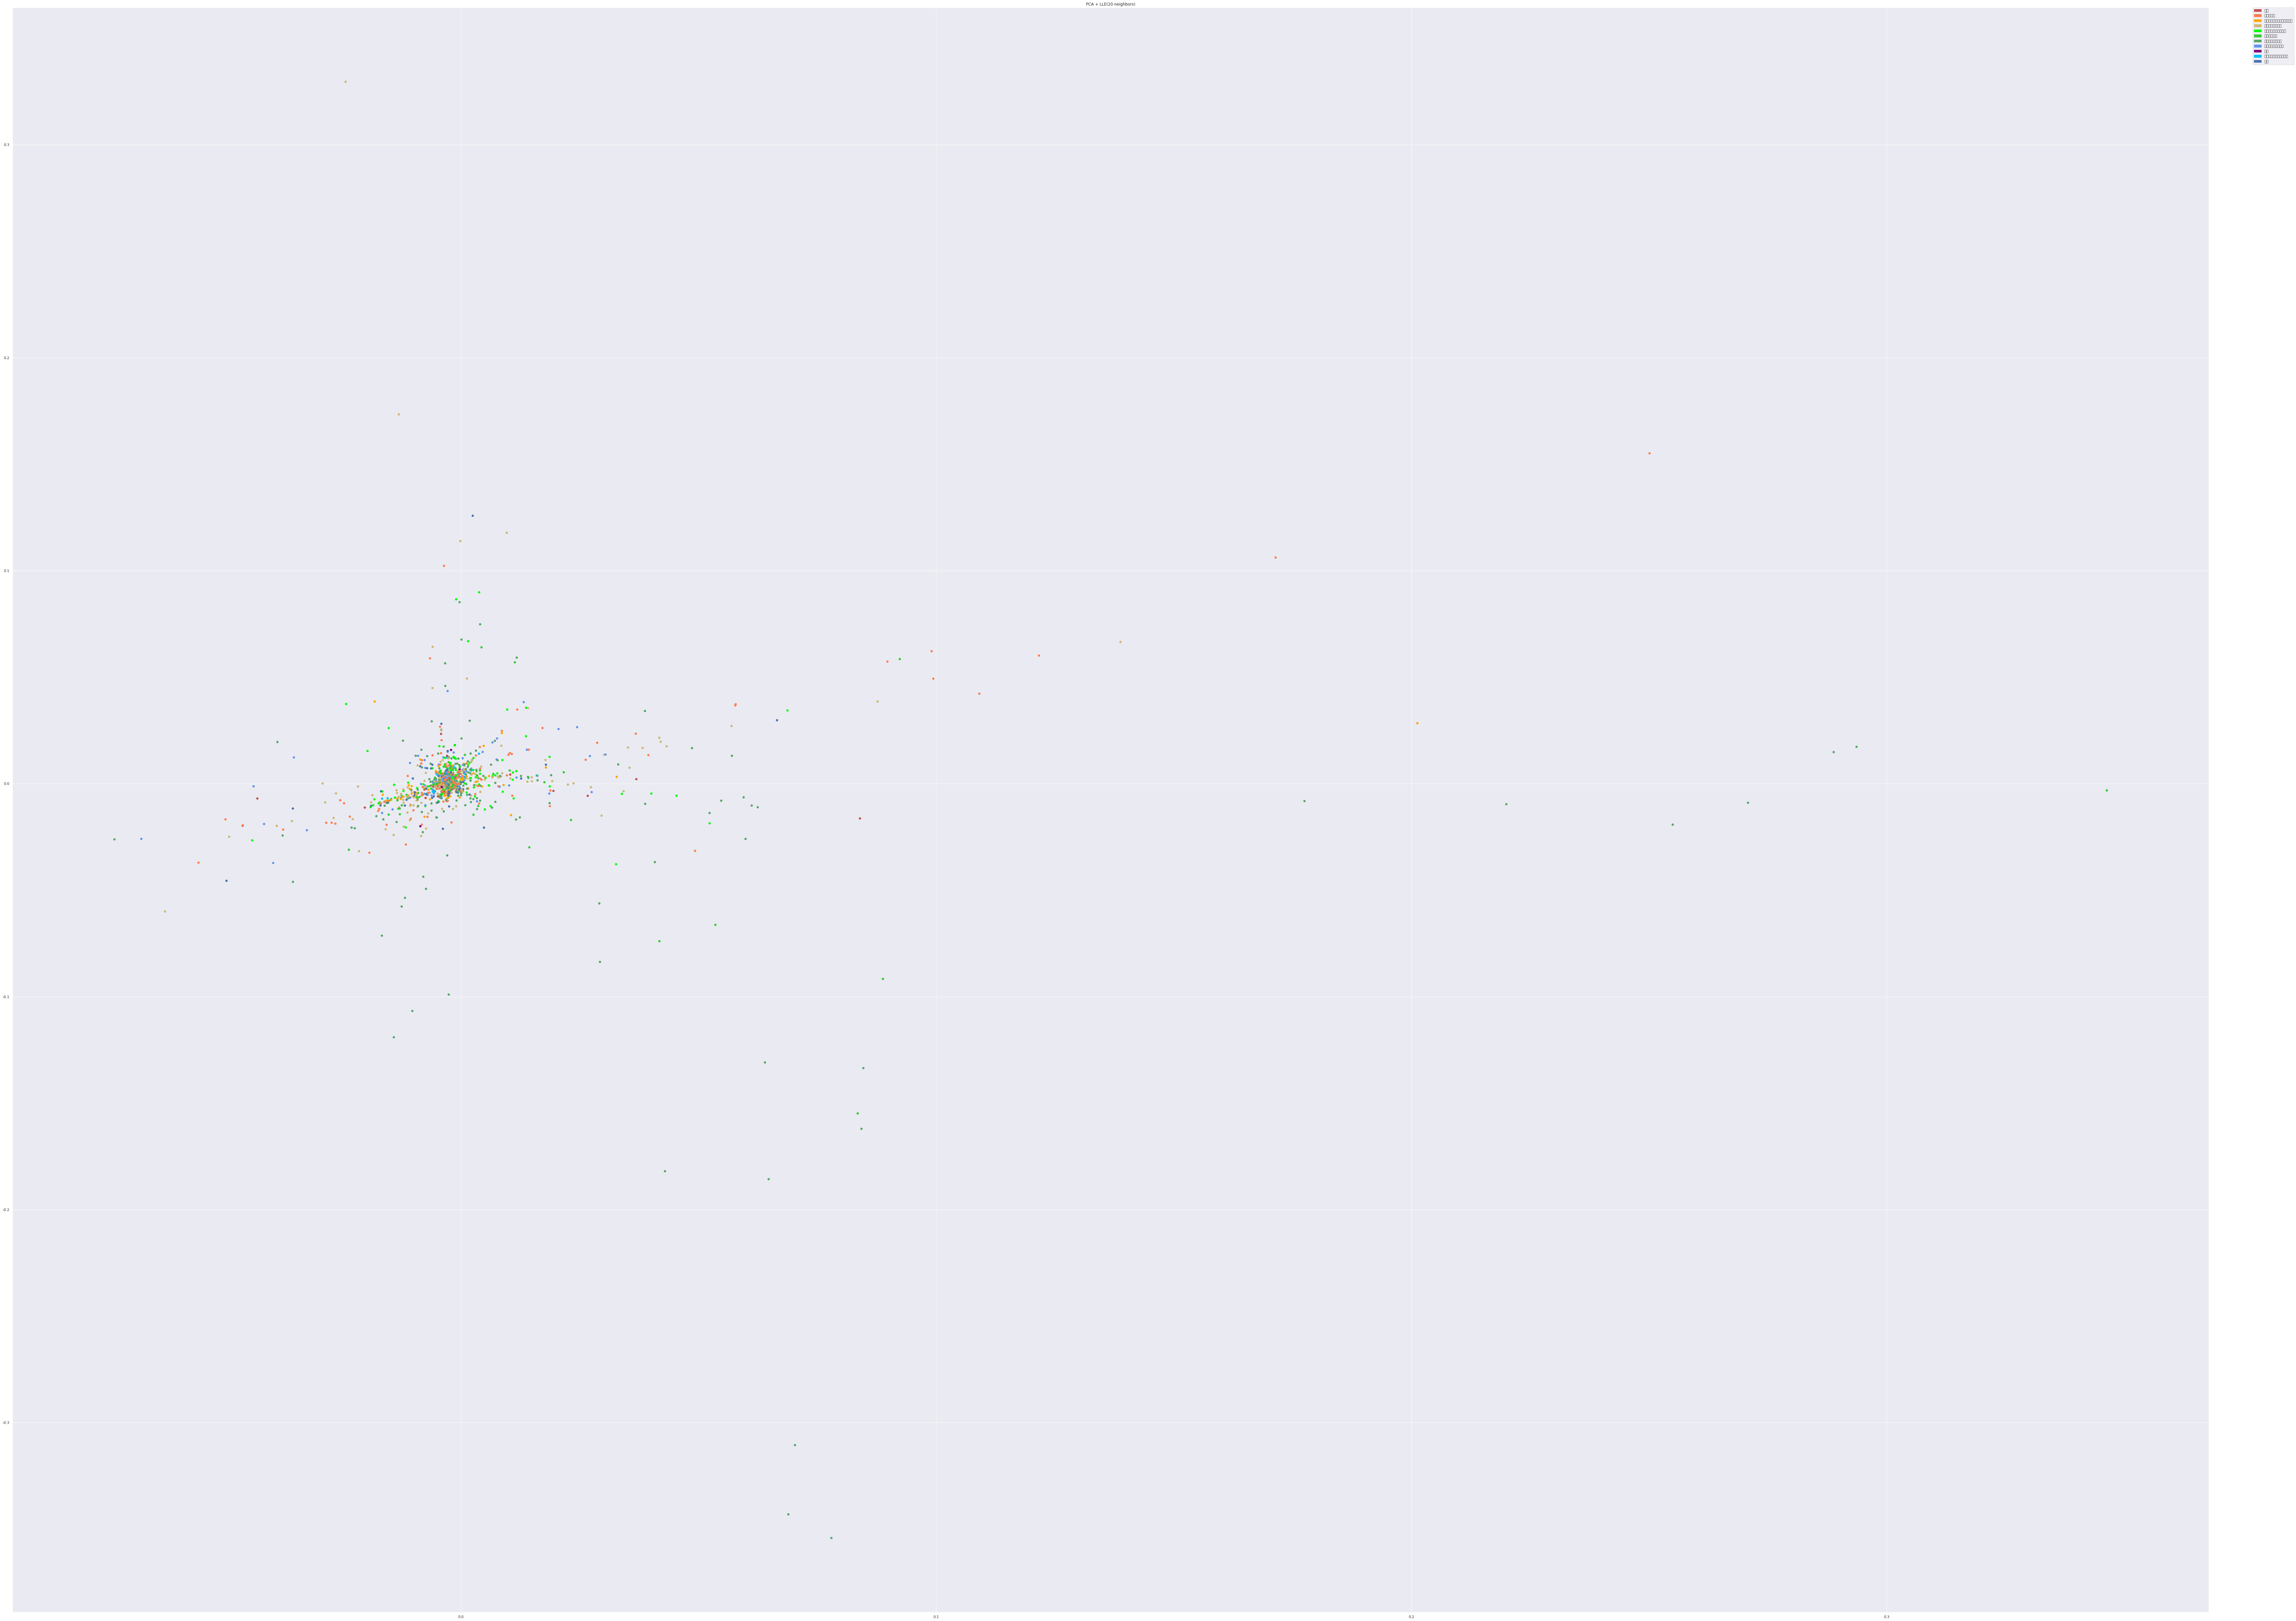

In [185]:
lle = LocallyLinearEmbedding(n_components = 2, n_neighbors = 20, n_jobs = -1)
X_lle = lle.fit_transform(PCA(n_components = 100).fit_transform(data))
plt.scatter(X_lle[:,0], X_lle[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('PCA + LLE(20 neighbors)')

#### LLE的前兩個case的圖長差不多，看似都不太好。PCA+LLE的結果看起來稍微好一些，但還是蠻多點重合在一起，仍然不是好的分類結果

### Q2.4

Text(0.5, 1.0, 'Kernel PCA with RBF Kernel)')

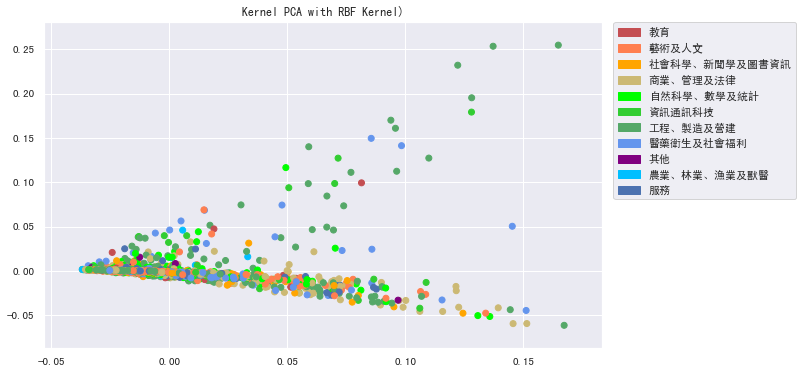

In [176]:
from sklearn.decomposition import KernelPCA
pca_rbf = KernelPCA(n_components= 2, kernel = "rbf", gamma = 0.0005)
X_pca_rbf = pca_rbf.fit_transform(new_stu)
plt.scatter(X_pca_rbf[:,0], X_pca_rbf[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('Kernel PCA with RBF Kernel)')

Text(0.5, 1.0, 'Kernel PCA with Cosine Kernel)')

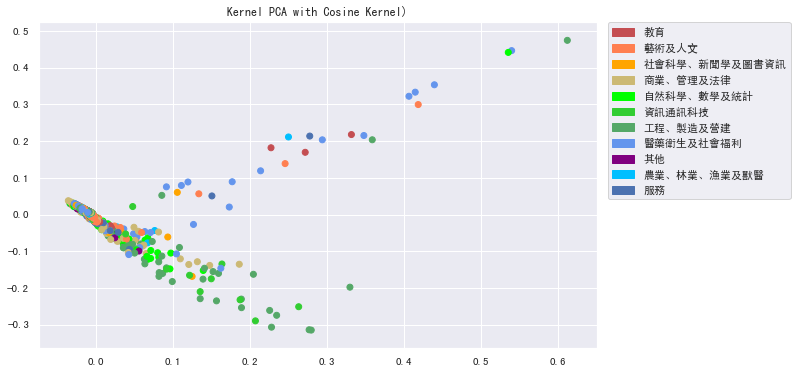

In [177]:
pca_cos = KernelPCA(n_components= 2, kernel = "cosine")
X_pca_cos = pca_cos.fit_transform(new_stu)
plt.scatter(X_pca_cos[:,0], X_pca_cos[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('Kernel PCA with Cosine Kernel)')

#### 看起來在原點附近都有大量重疊的點，應繼續尋找較好的分類器

### Q2.5

Text(0.5, 1.0, 't-SNE with Euclidian metric')

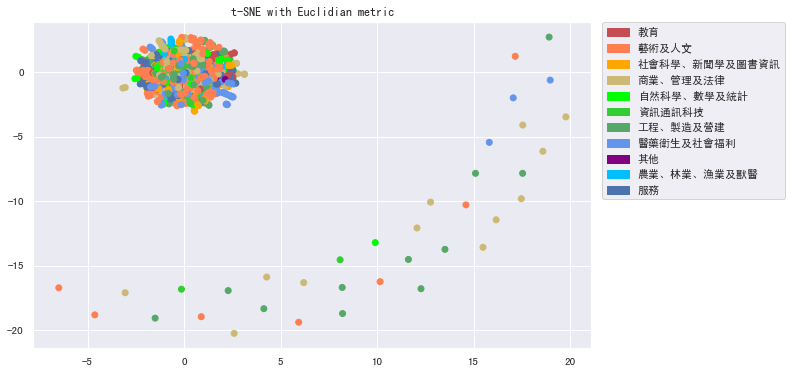

In [181]:
from sklearn.manifold import TSNE
tsne_eud = TSNE(n_components=2, init='random', random_state=0, metric = 'euclidean', learning_rate=15)
X_tsne_eud = tsne_eud.fit_transform(new_stu)
plt.scatter(X_tsne_eud[:,0], X_tsne_eud[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('t-SNE with Euclidian metric')

Text(0.5, 1.0, 't-SNE with Cosine metric')

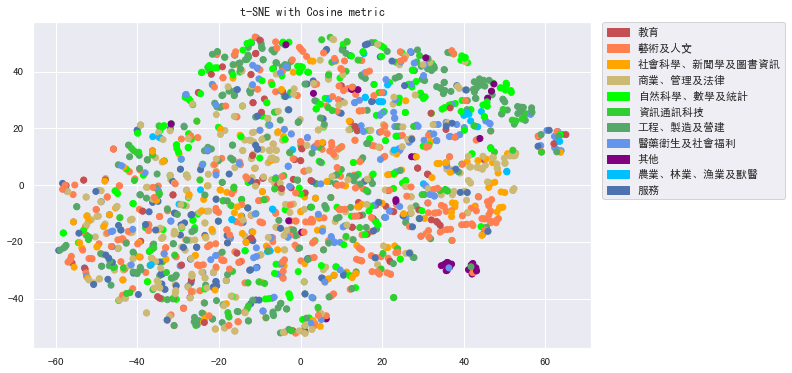

In [179]:
from sklearn.manifold import TSNE
tsne_eud = TSNE(n_components=2, init='random', random_state=0, metric = 'cosine', learning_rate=15)
X_tsne_eud = tsne_eud.fit_transform(new_stu)
plt.scatter(X_tsne_eud[:,0], X_tsne_eud[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('t-SNE with Cosine metric')

Text(0.5, 1.0, 't-SNE with Jaccard metric')

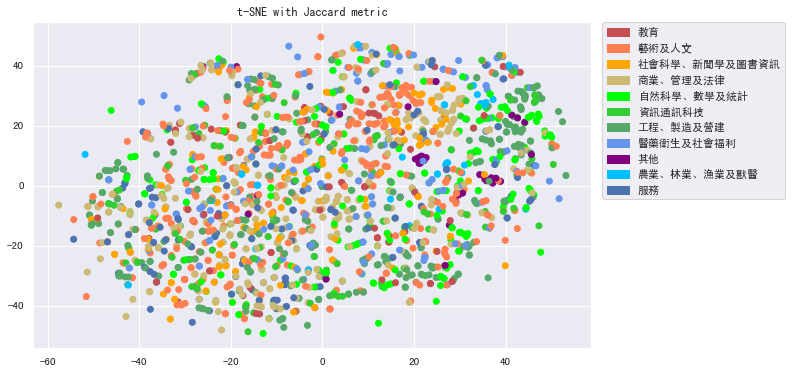

In [180]:
from sklearn.manifold import TSNE
tsne_eud = TSNE(n_components=2, init='random', random_state=0, metric = 'jaccard', learning_rate=15)
X_tsne_eud = tsne_eud.fit_transform(new_stu)
plt.scatter(X_tsne_eud[:,0], X_tsne_eud[:,1], c = label_color)
plt.legend(handles = patchList, bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad=0.)
plt.title('t-SNE with Jaccard metric')

#### 看起來t-SNE with Jaccard metric的表現可能是最好的了，t-SNE with cosine metric也差不多，而t-SNE with Euclidian就表現得很糟。

### Q2.6

### 根據前面的結果，我選擇最後的t-SNE with Jacaard來實作本題 

In [187]:
import seaborn as sns
sns.set_color_codes("pastel")
sns.set(rc={'figure.figsize':(120,90)})
sns.set(font=['sans-serif'])
sns.set_style("darkgrid",{"font.sans-serif":['simhei']})

# prepare output text
uname['output'] = uname['school_name_abbr'] + uname['department_name_abbr']
output = dep_category_map.merge(uname.loc[:,['department_id','output']], 
                       on='department_id', how='inner')

final_plot = sns.scatterplot(x=X_tsne_eud[:,0], y=X_tsne_eud[:,1], hue=dep_category_map.iloc[:,1], y_jitter=True)

for line in range(0,X_tsne_eud.shape[0]):
     final_plot.text(X_tsne_eud[line,0]+0.2,
                     X_tsne_eud[line,1],
                     output.iloc[line,-1],
                     horizontalalignment='left',
                     fontsize=10,
                     color='gray', weight='semibold')
plt.savefig('output2.png')
plt.close()